In [3]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)


with open("./DATACON_data/cpzp_persons.pkl", "rb") as f:
    cpzp_persons: list[Person] = pickle.load(f)

with open("./DATACON_data/ozp_persons.pkl", "rb") as f:
    ozp_persons: list[Person] = pickle.load(f)

In [4]:
persons = sorted(cpzp_persons, key=lambda p: p.id)
dead_persons = [p for p in persons if p.died_at and p.vaccines]

dead_indexes_map = {
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
}

first_pr_from_first_dose_map = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}

first_pr_map_no_vax_segregation = {}

first_pr_map_vax_segregation = {
    0: {},
    1: {},
    2: {},
    3: {},
    4: {},
    5: {},
    6: {},
    7: {},
    8: {},
}


for p in dead_persons:
    last_vax_date = p.vaccines[-1] if p.vaccines else None
    if last_vax_date:
        day_of_death = p.died_at
        # if day_of_death.day == 1:
        #     next_month = (day_of_death.replace(day=28) + timedelta(days=4)).replace(
        #         day=1
        #     )
        #     day_of_death = next_month - timedelta(days=1)

        days_after_last_vax = (day_of_death - last_vax_date).days
        if days_after_last_vax < 0:
            continue
        if days_after_last_vax not in dead_indexes_map[len(p.vaccines)]:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] = 1
        else:
            dead_indexes_map[len(p.vaccines)][days_after_last_vax] += 1


def find_closest_date(target_date: datetime, dates: list[datetime]):
    if not dates:
        return None
    return max(dates, key=lambda d: abs(target_date - d))


n_of_imunosuppresives = 0
n_of_corts = 0
for p in persons:
    first_prescription_date = p.prescriptions[0].date if p.prescriptions else None
    first_vax_date = p.vaccines[0] if p.vaccines else None

    if first_prescription_date and first_vax_date:
        if not p.prescriptions[0].equiv_sloucenina:
            n_of_imunosuppresives += 1
            continue
        else:
            n_of_corts += 1
        closest_vax_date = (
            find_closest_date(first_prescription_date, p.vaccines)
            if p.vaccines
            else None
        )

        days_after_first_prescription = (first_vax_date - first_prescription_date).days
        if days_after_first_prescription not in first_pr_map_no_vax_segregation:
            first_pr_map_no_vax_segregation[days_after_first_prescription] = 1
        else:
            first_pr_map_no_vax_segregation[days_after_first_prescription] += 1

        if (
            days_after_first_prescription
            not in first_pr_from_first_dose_map[
                len(p.vaccines)
            ]  # kolik má člověk celkově vakcín
        ):
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] = 1
        else:
            first_pr_from_first_dose_map[len(p.vaccines)][
                days_after_first_prescription
            ] += 1

        if closest_vax_date:
            days_after_closest_vax = (closest_vax_date - first_prescription_date).days
            if (
                days_after_closest_vax
                not in first_pr_map_vax_segregation[len(p.vaccines)]
            ):
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] = 1
            else:
                first_pr_map_vax_segregation[len(p.vaccines)][
                    days_after_closest_vax
                ] += 1

print(n_of_imunosuppresives)
print(n_of_corts)

4343
198257


2.1452631578947368


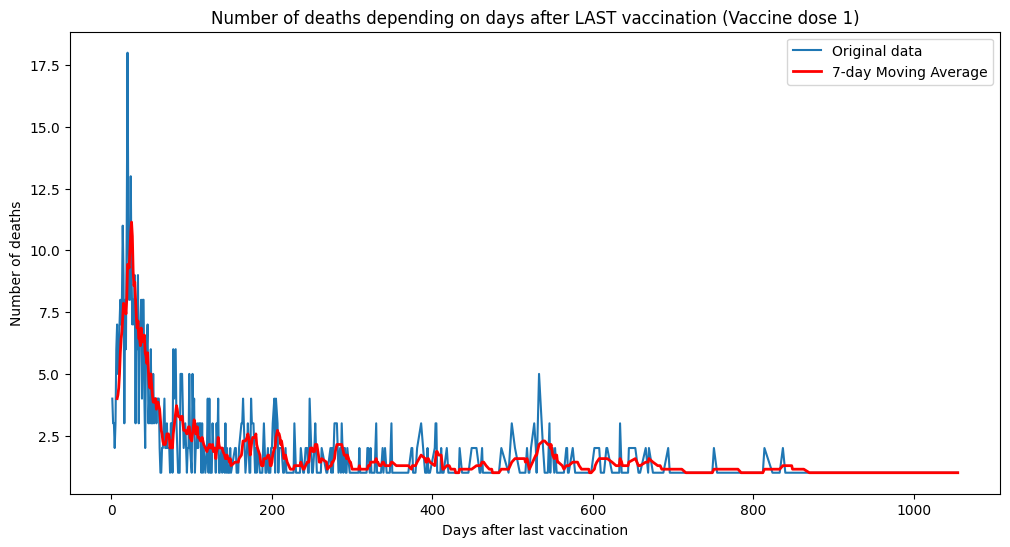

4.103286384976526


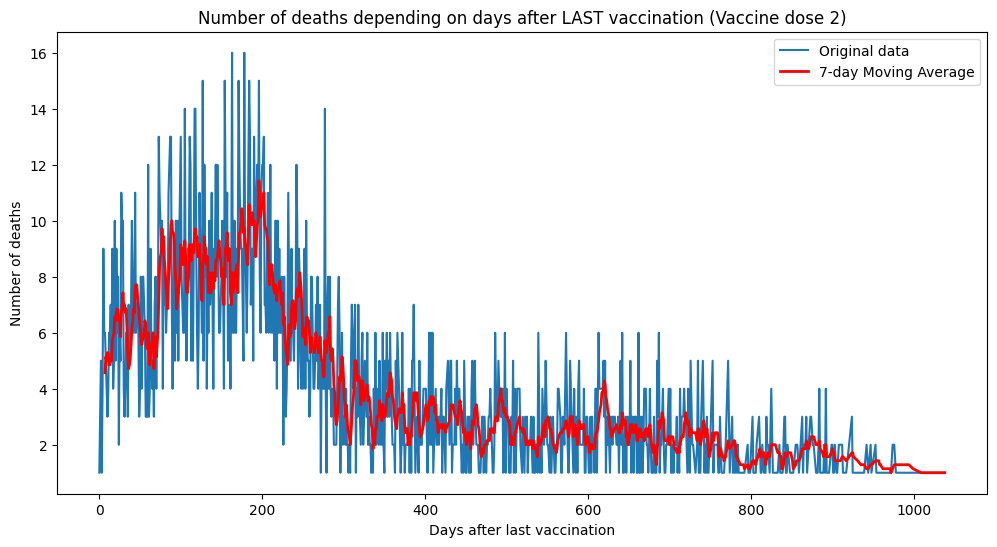

5.7201017811704835


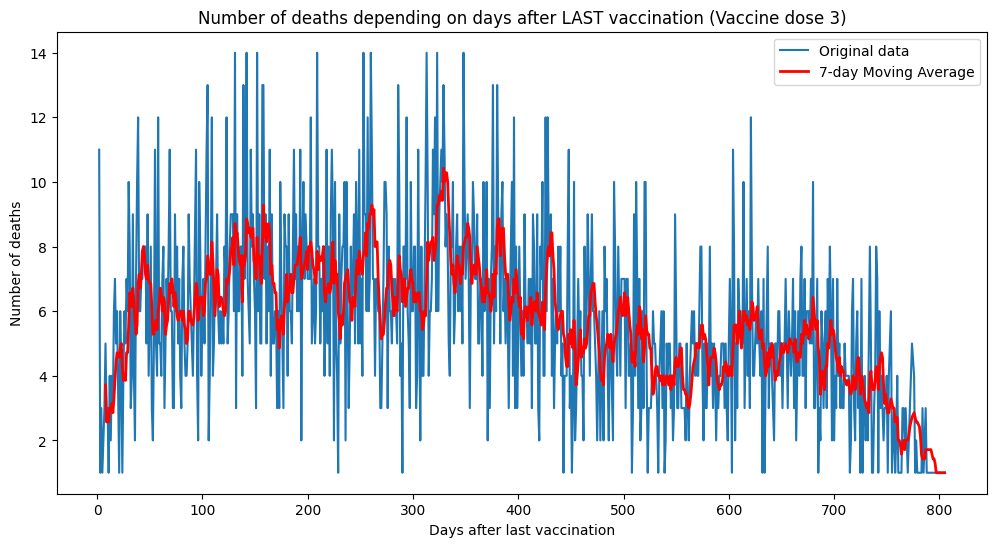

2.5946547884187083


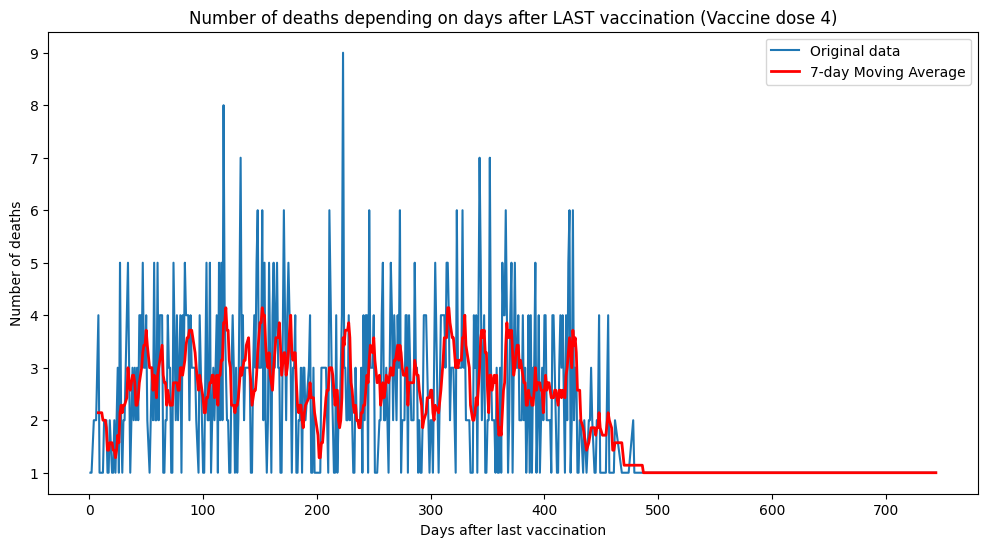

1.25


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [5]:
# === HVE per each dose ===
for vaccine_amount, indexes_map in dead_indexes_map.items():
    draw_chart(
        indexes_map,
        "Days after last vaccination",
        "Number of deaths",
        f"Number of deaths depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
    )

2.980283425754775


<Figure size 1200x600 with 0 Axes>

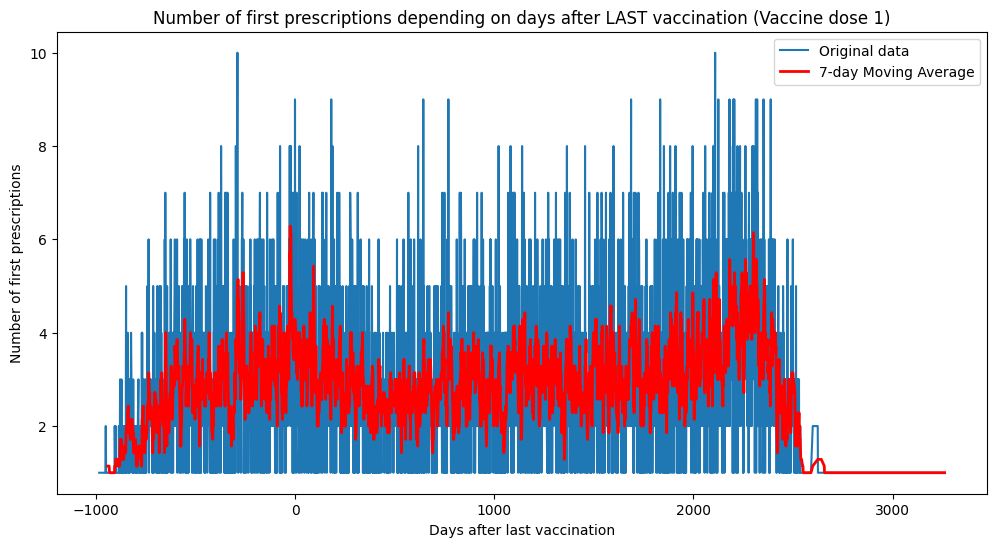

15.974365893146249


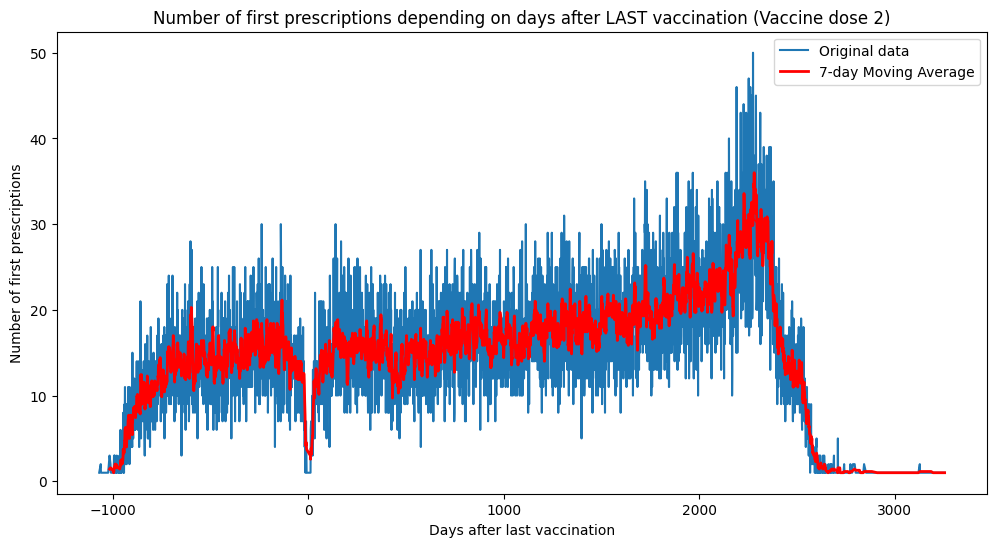

24.52102803738318


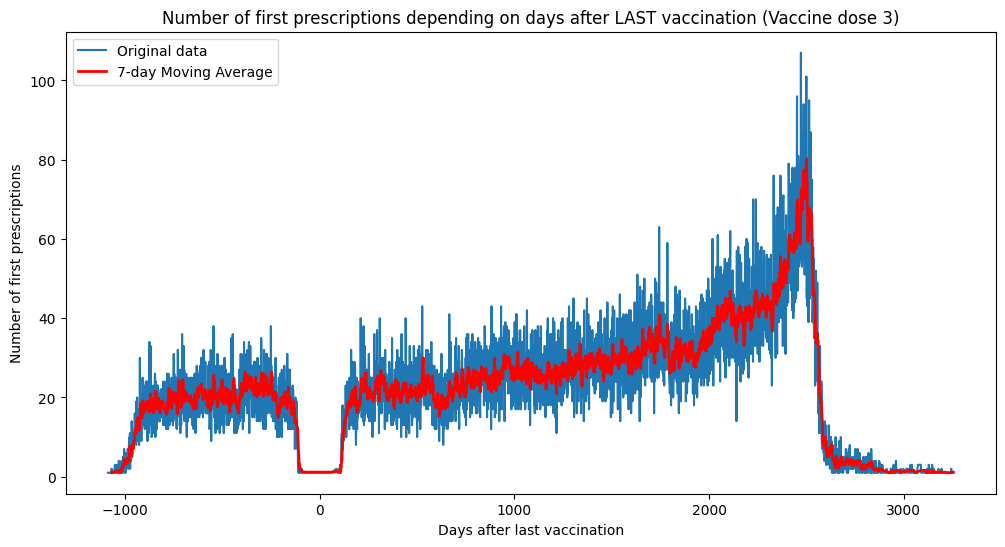

6.21735604217356


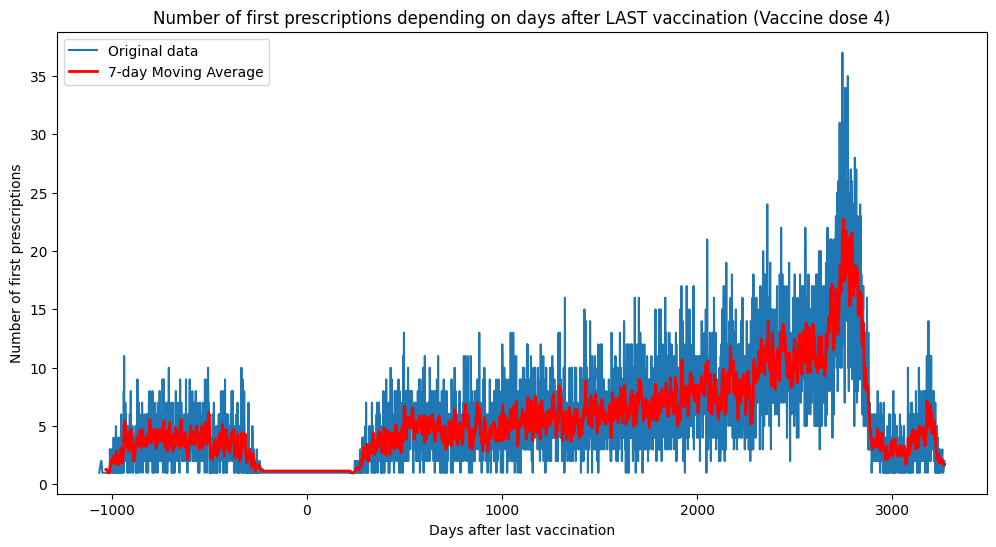

3.777137367915466


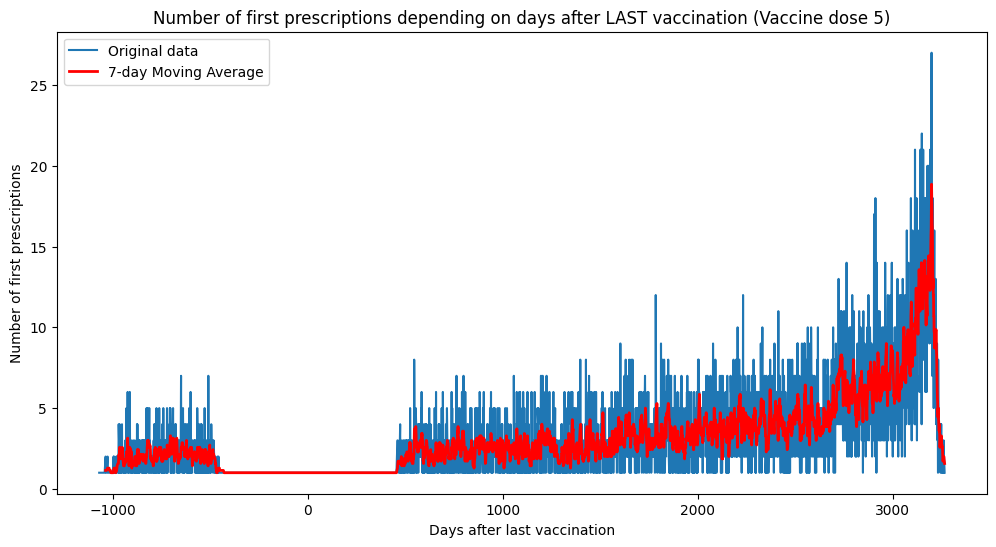

1.0406504065040652


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [6]:
# === Number of first prescriptions depending on days after LAST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_map_vax_segregation.items():
    draw_chart(
        indexes_map,
        "Days after last vaccination",
        "Number of first prescriptions",
        f"Number of first prescriptions depending on days after LAST vaccination (Vaccine dose {vaccine_amount})",
    )

2.980283425754775


<Figure size 1200x600 with 0 Axes>

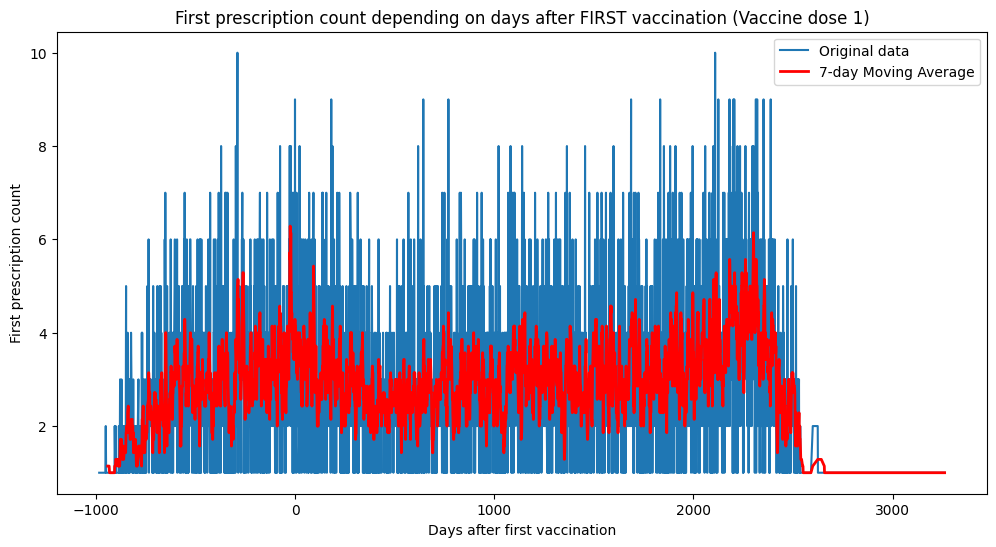

16.431029697474326


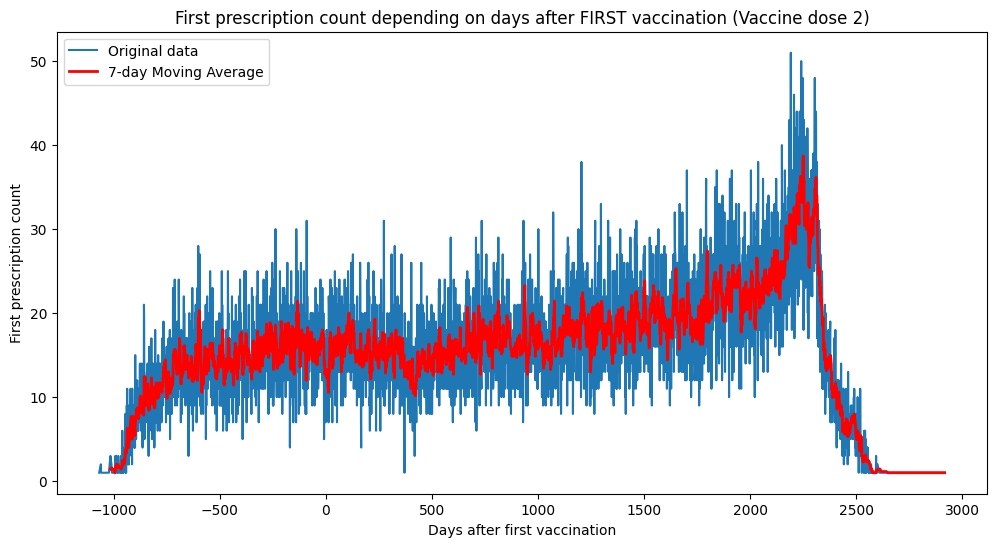

26.74263873159683


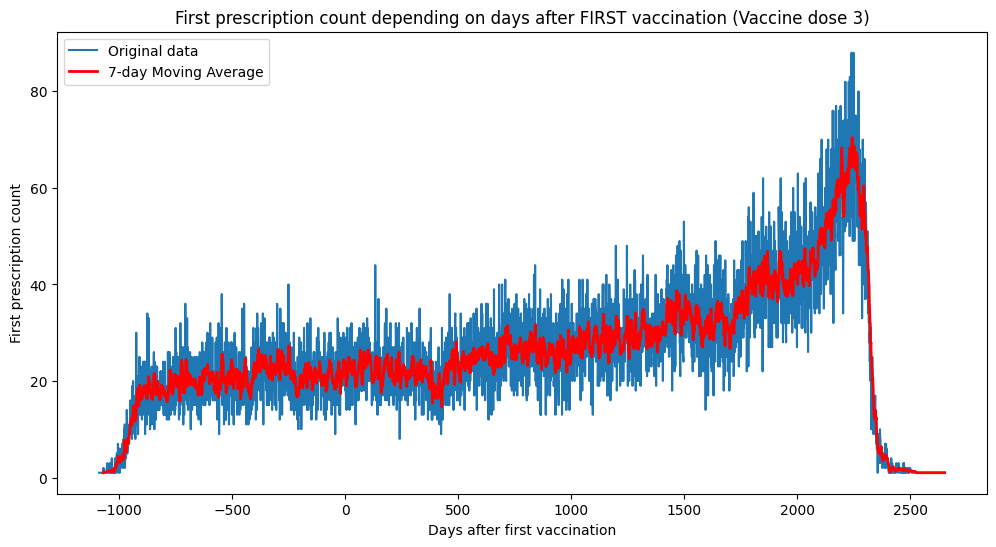

6.8223079204983685


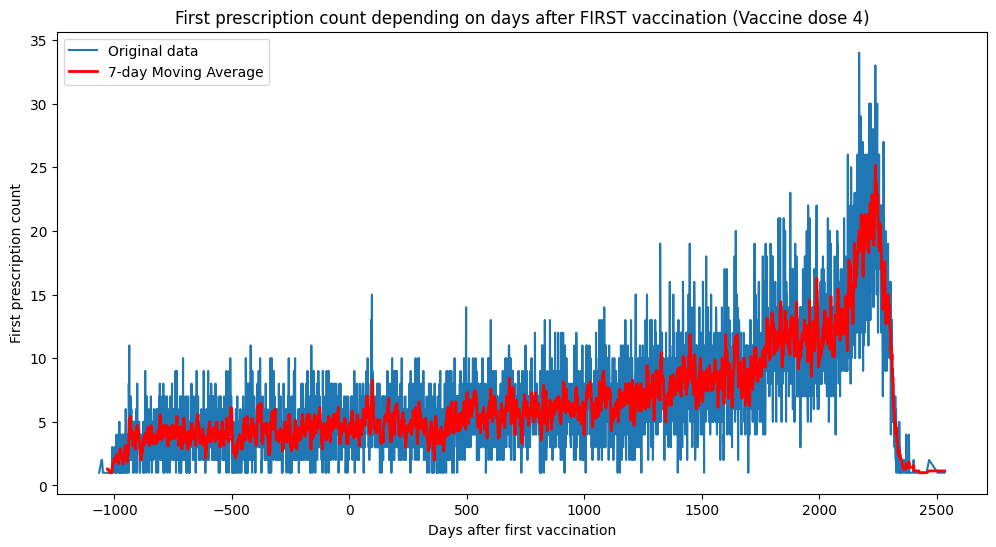

3.785622593068036


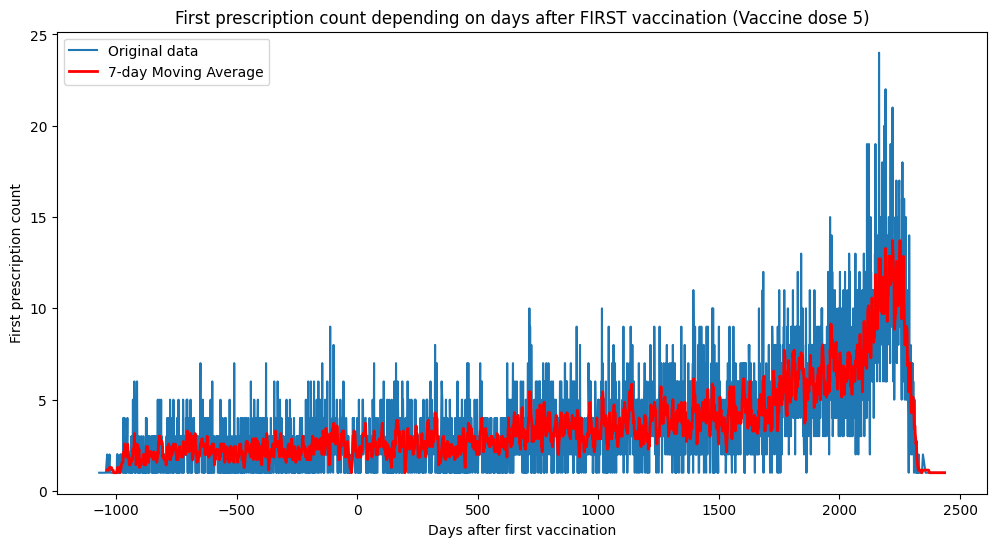

1.0


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [7]:
# === Number of first prescriptions depending on days after FIRST vaccination (ONE BY ONE for each dose) ===

for vaccine_amount, indexes_map in first_pr_from_first_dose_map.items():
    draw_chart(
        indexes_map,
        "Days after first vaccination",
        "First prescription count",
        f"First prescription count depending on days after FIRST vaccination (Vaccine dose {vaccine_amount})",
    )

53.20907139023081


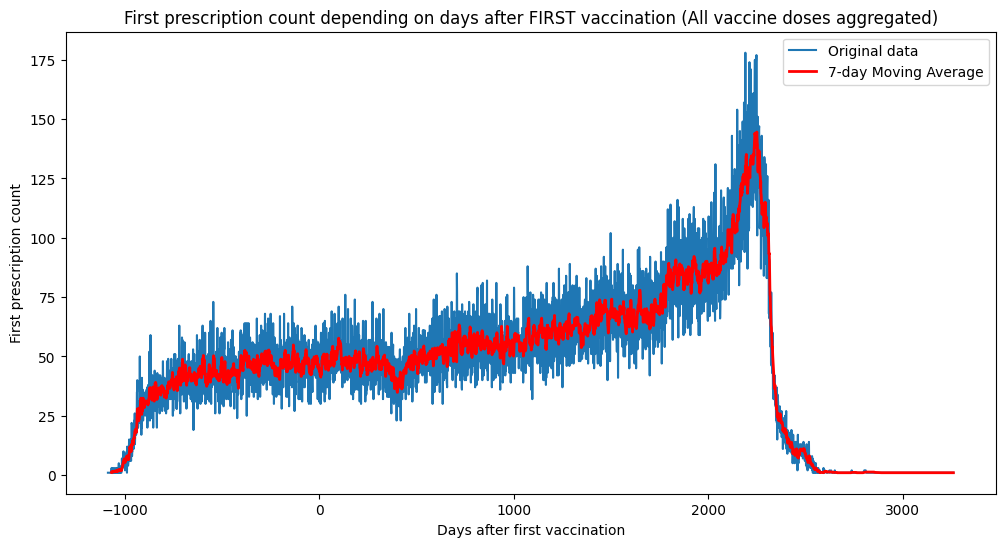

In [8]:
# === Number of first prescriptions depending on days after FIRST vaccination (ALL DOSES AGGREGATED) ===

draw_chart(
    first_pr_map_no_vax_segregation,
    "Days after first vaccination",
    "First prescription count",
    "First prescription count depending on days after FIRST vaccination (All vaccine doses aggregated)",
)